In [13]:
import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.layers import Embedding, Conv1D, GlobalMaxPool1D, Dropout, Dense
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
import gensim
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.linear_model import LogisticRegressionCV,LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,accuracy_score
from keras import metrics
import pickle
%matplotlib inline

%load_ext autoreload
%autoreload 2
import helper

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Fasttext facebook
PubMed PMC word vectors
Gensim word2vec

In [7]:
documents_train, target_train = helper.load_binary_data()

In [20]:
documents_test, ids_test = helper.load_binary_data("data/test_binary.csv")

# TfIdf-BoW model

In [9]:
count_vect = CountVectorizer(binary=False, max_df=0.9, min_df=3, lowercase=True, strip_accents="unicode")
count_vect.fit(documents_train)
pickle.dump(count_vect, open("models/valentin/vectorizer.p", "wb"))
X_train_counts = count_vect.transform(documents_train)
tfidf_transformer = TfidfTransformer()
X = tfidf_transformer.fit_transform(X_train_counts)
X.shape

(2155, 8069)

# Basic Keras model

In [46]:
from keras.layers import Dense, Dropout

In [14]:
def create_model():
    model = Sequential()
    model.add(Dense(16, input_shape=(X.shape[1],), activation="relu"))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer='rmsprop',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

In [51]:
acc = []
for i in range(10):
    print("Loop {}".format(str(i)))
    X_train, X_test, y_train, y_test = train_test_split(X, target, test_size=0.1)
    model = create_model()
    model.fit(X_train.todense(), y_train, validation_split=0.1, epochs=20, verbose=0)
    yhat = model.predict(X_test.todense())
    acc_i = helper.score_prediction(y_test, yhat, acc_only=True)
    acc.append(acc_i)

print("Average Accuracy: {:.2%}".format(np.mean(acc)))
print(acc)

Loop 0
Loop 1
Loop 2
Loop 3
Loop 4
Loop 5
Loop 6
Loop 7
Loop 8
Loop 9
Average Accuracy: 95.69%
[0.96759259259259256, 0.95833333333333337, 0.96296296296296291, 0.95370370370370372, 0.94907407407407407, 0.96759259259259256, 0.97222222222222221, 0.94907407407407407, 0.93055555555555558, 0.95833333333333337]


             precision    recall  f1-score   support

          0       0.95      1.00      0.98       103
          1       1.00      0.96      0.98       113

avg / total       0.98      0.98      0.98       216

Accuracy: 97.69%
AUC: 1.0


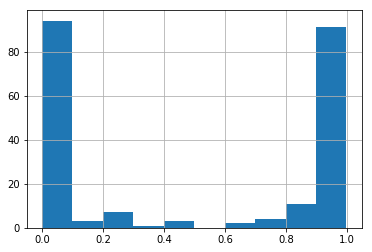

In [22]:
yhat = model.predict(X_test.todense())
helper.score_prediction(y_test, yhat)

## Full model

In [10]:
X_submission = count_vect.transform(documents_test)

In [17]:
model = create_model()
model.fit(X.todense(), target_train.values, epochs=20, verbose=1)
model.evaluate(X.todense(), target_train.values)
yhat = model.predict(X_submission.todense())

In [41]:
helper.create_binary_submission(yhat, ids_test, "submissions/valentin/")

# CNN with embedding layer

In [56]:
documents_train, target_train = helper.load_multiclass_data()

In [57]:
stoplist = list(gensim.parsing.preprocessing.STOPWORDS) + ["<span"] + list(range(0,9))
def word_is_valid(word):
    return word not in stoplist and len(word) > 2 and len(word) < 20

texts = [[word for word in document.lower().split() if word_is_valid(word)] for document in documents_train]

In [58]:
dictionary = gensim.corpora.Dictionary(texts)
print(dictionary)
dictionary.filter_extremes(no_above=0.9)
print(dictionary)

Dictionary(180083 unique tokens: ['insulinlike', 'growth', 'factor', 'associated', 'diabetic']...)
Dictionary(46109 unique tokens: ['insulinlike', 'growth', 'factor', 'associated', 'diabetic']...)


In [59]:
token2id = dictionary.token2id

In [60]:
corpus = [[token2id.get(word) for word in text if token2id.get(word, False)] for text in texts]

In [61]:
maxlen = 1000
X_sequential = sequence.pad_sequences(corpus, maxlen=maxlen)

In [62]:
X_train, X_test, y_train, y_test = train_test_split(X_sequential, target_train.values, test_size=0.1)

In [65]:
def create_embedding_cnn_model(output_dim=1):
    embedding_dim = 100
    filters = 250
    kernel_size = 3
    model = keras.models.Sequential()
    model.add(Embedding(input_dim=len(token2id), output_dim=embedding_dim, input_length=maxlen))
    model.add(Dropout(0.2))
    model.add(Conv1D(filters,
                 kernel_size,
                 padding='valid',
                 activation='relu',
                 strides=1))
    # we use max pooling:
    model.add(Dropout(0.5))
    model.add(GlobalMaxPool1D())
    model.add(Dropout(0.5))
    model.add(Dense(64, activation="relu"))
    model.add(Dropout(0.5))
    model.add(Dense(output_dim, activation='sigmoid'))
    model.compile(optimizer='rmsprop',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

In [66]:
model = create_embedding_cnn_model(output_dim=23)
model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['accuracy'])
model.fit(X_train, y_train, validation_split=0.1, epochs=10, batch_size=256)

Train on 36925 samples, validate on 4103 samples
Epoch 1/10
36925/36925 [==============================] - 16s - loss: 0.2226 - acc: 0.9357 - val_loss: 0.2406 - val_acc: 0.9572
Epoch 2/10
36925/36925 [==============================] - 16s - loss: 0.1635 - acc: 0.9569 - val_loss: 0.1980 - val_acc: 0.9575
Epoch 3/10
36925/36925 [==============================] - 16s - loss: 0.1534 - acc: 0.9570 - val_loss: 0.1797 - val_acc: 0.9576
Epoch 4/10
36925/36925 [==============================] - 16s - loss: 0.1431 - acc: 0.9575 - val_loss: 0.1636 - val_acc: 0.9577
Epoch 5/10
36925/36925 [==============================] - 16s - loss: 0.1345 - acc: 0.9580 - val_loss: 0.1491 - val_acc: 0.9583
Epoch 6/10
36925/36925 [==============================] - 17s - loss: 0.1283 - acc: 0.9585 - val_loss: 0.1467 - val_acc: 0.9583
Epoch 7/10
36925/36925 [==============================] - 16s - loss: 0.1235 - acc: 0.9590 - val_loss: 0.1360 - val_acc: 0.9582
Epoch 8/10
36925/36925 [==============================]

In [94]:
yhat = model.predict(X_test)
_ = helper.score_prediction(y_test, yhat, binary=False)

             precision    recall  f1-score   support

          0       0.00      0.00      0.00        40
          1       0.30      0.39      0.34       205
          2       0.55      0.71      0.62       487
          3       0.41      0.54      0.47       239
          4       0.47      0.53      0.50       249
          5       0.33      0.02      0.03        63
          6       0.51      0.40      0.45        78
          7       0.31      0.42      0.36       106
          8       0.00      0.00      0.00        99
          9       0.40      0.54      0.46       268
         10       0.39      0.22      0.28       124
         11       0.50      0.02      0.04        86
         12       0.49      0.65      0.56       520
         13       0.45      0.52      0.48       312
         14       0.40      0.47      0.43       162
         15       0.00      0.00      0.00        55
         16       0.00      0.00      0.00        36
         17       0.24      0.23      0.24   

/home/valentin/bin/anaconda3/envs/tensorflow/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
